# Ejemplo de uso de los datos de Santa Maria y Stanford

El archivo muestra las siguientes funciones:
1. Cargar datos *tensorflow* de Santa María y Stanford.
2. Dividir datos en entrenamiento y testeo con las clases balanceadas y para un valor de división deseada.
3. Visualizar imágenes de **PET**, **Body CT** y **Torax3d**
Se muestra un ejemplo de uso de carga de los datos de santa maría y Stanford.

**IMPORTANTE**: Se deben descargar los datos de Santa María y de Stanford de la forma en que se indica en el README. Es necesario haber instalado *tensorflow* y *tensorflow_datasets* como se indica en el readme también para cargar los datos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import resource
import tensorflow_datasets as tfds
import random
import pandas as pd
import cv2
import csv
from pathlib import Path

2023-10-25 14:35:38.756994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/roberto/anaconda3/envs/lung_radiomics/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# se cargan los datos de santa maría y stanford
# Para el ejemplo se cargan los datos de los exámenes torax3d, se puede reemplazar con 'pet' o 'body'

sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)
stanford_dataset, stanford_info = tfds.load('stanford_dataset/ct', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/pet', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)

2023-10-25 14:35:48.776961: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)



def get_training_testing_sm_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    print(neg_patients)
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset


def get_training_testing_stanford_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    pos_patients = []
    neg_patients = []
    # setea la semilla random
    random.seed(random_seed)
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: stanford_dataset[patient] for patient in training_patients}
    testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset

## Visualizar imágenes

In [21]:
def visualizeImgMask(img, mask, pet):

    """
  Función para visualizar las imágenes, máscaras y fusión.
  INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
  PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
  sólo por un tema de convención de la visualización del PET.
    """
    mask = mask.numpy()
    img = img.numpy()

    if(pet == 1):
        f = plt.figure(figsize=(10,10), frameon=True)
        f.add_subplot(1, 3, 1)
        plt.title("PET")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray_r')
        f.add_subplot(1, 3, 2)
        plt.title("Mask")
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='Blues')
        f.add_subplot(1, 3, 3)
        plt.title("Fusion")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray_r')
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='gnuplot', alpha= 0.6)
        plt.show()

    else:
        f = plt.figure(figsize=(10,10), frameon=True)
        f.add_subplot(1, 3, 1)
        plt.title("CT")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray')
        f.add_subplot(1, 3, 2)
        plt.title("Mask")
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='Blues')
        f.add_subplot(1, 3, 3)
        plt.title("Fusion")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray')
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='gnuplot', alpha= 0.6)
        plt.show()


['sm_013', 'sm_014', 'sm_015', 'sm_016', 'sm_017', 'sm_018', 'sm_019', 'sm_020', 'sm_021', 'sm_022', 'sm_023', 'sm_024', 'sm_025', 'sm_026', 'sm_027', 'sm_028', 'sm_029', 'sm_030', 'sm_031', 'sm_032', 'sm_033', 'sm_034', 'sm_035']


2023-10-25 14:47:33.647865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-25 14:47:33.835636: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Patient ID: sm_007
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)
Label: 1


2023-10-25 14:47:33.871877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-25 14:47:33.938632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-10-25 14:47:33.939235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/

Patient ID: sm_012
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)


2023-10-25 14:47:34.163784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


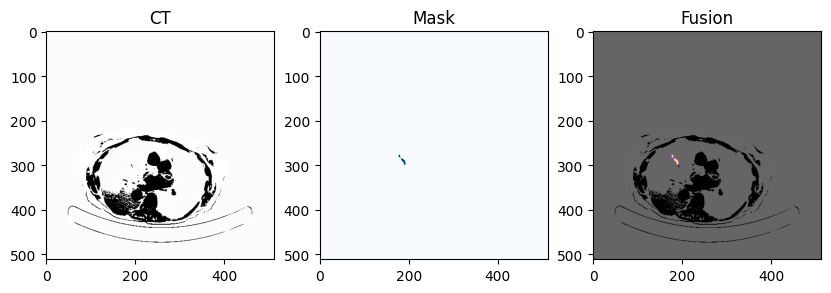

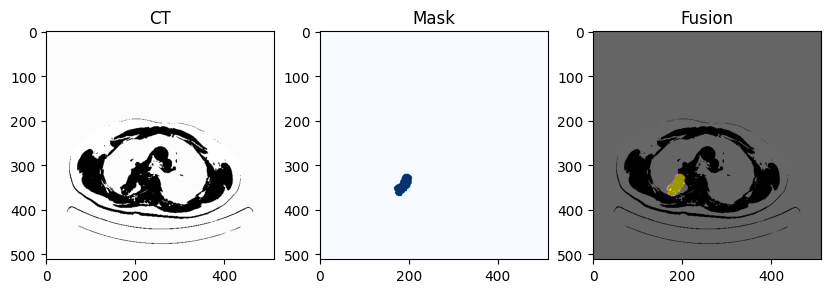

In [22]:
training_ds, testing_ds = get_training_testing_sm_datasets()


# Iterate through the training dataset
img_exam_train, mask_exam_train = None, None
img_exam_test, mask_exam_test = None, None
for patient_id, img_exam_train, mask_exam_train, label in training_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_train.shape)
    print("Mask Exam Shape:", mask_exam_train.shape)
    print("Label:", label.numpy())
    break


# Iterate through the testing dataset
for patient_id, img_exam_test, mask_exam_test, label in testing_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_test.shape)
    print("Mask Exam Shape:", mask_exam_test.shape)
    break


visualizeImgMask(img_exam_train, mask_exam_train, pet=False)
visualizeImgMask(img_exam_test, mask_exam_test, pet=False)

2023-10-25 14:47:35.664979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-25 14:47:35.757293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-10-25 14:47:35.757919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_

Patient ID: R01-146
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)
Label: 1


2023-10-25 14:47:36.018190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-25 14:47:36.075534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-10-25 14:47:36.078075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder

Patient ID: AMC-023
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)


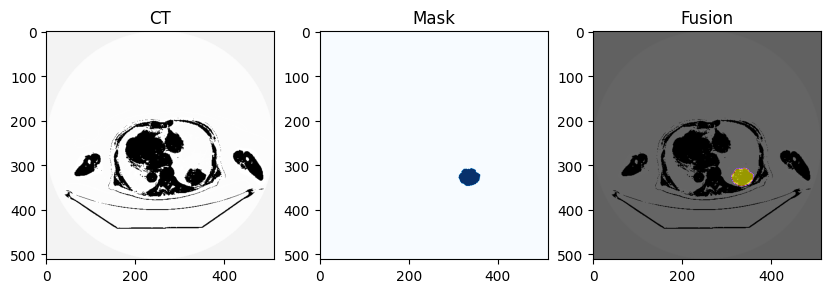

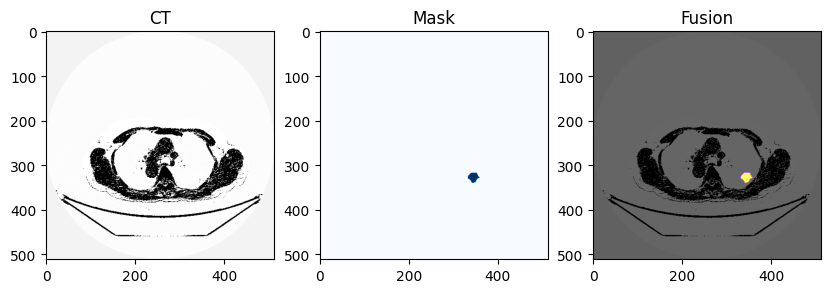

In [23]:
training_stanford, testing_stanford = get_training_testing_stanford_datasets()

# Iterate through the training dataset
stanford_img_exam_train, stanford_mask_exam_train = None, None
stanford_img_exam_test, stanford_mask_exam_test = None, None
for patient_id, stanford_img_exam_train, stanford_mask_exam_train, label in training_stanford:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", stanford_img_exam_train.shape)
    print("Mask Exam Shape:", stanford_mask_exam_train.shape)
    print("Label:", label.numpy())
    break


# Iterate through the testing dataset
for patient_id, stanford_img_exam_test, stanford_mask_exam_test, label in testing_stanford:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", stanford_img_exam_test.shape)
    print("Mask Exam Shape:", stanford_mask_exam_test.shape)
    break


visualizeImgMask(stanford_img_exam_train, stanford_mask_exam_train, pet=False)
visualizeImgMask(stanford_img_exam_test, stanford_mask_exam_test, pet=False)

## Extraer el ROI de los examenes

In [58]:
def roiExtraction (img,mask,margin):
    """
  Función para extraer el ROI donde se encuentra el tumor en una imagen.
  INPUT: imagen y máscaras numpy array 2D.
  margin: corresponde al número de pixeles como margen por fuera de los pixeles de la máscara.
  OUTPUT: Devuelve el ROI.
  """

    roi_extract = []

    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)
    roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    return roi

import numpy as np
import cv2

def roiExtractionSize(img, mask, total_size):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)

    # Calculate the center of the mask.
    center_row = int(np.mean(index[0]))
    center_col = int(np.mean(index[1]))

    # Calculate the size of the ROI based on the total size.
    half_size = total_size // 2

    # Determine ROI boundaries with the margin.
    min_row = max(0, center_row - half_size)
    max_row = min(mask_instance.shape[0], center_row + half_size)
    min_col = max(0, center_col - half_size)
    max_col = min(mask_instance.shape[1], center_col + half_size)

    # Calculate the width and height of the ROI.
    roi_height = max_row - min_row
    roi_width = max_col - min_col

    # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
    if roi_height < total_size:
        margin = (total_size - roi_height) // 2
        min_row -= margin
        max_row += margin

    if roi_width < total_size:
        margin = (total_size - roi_width) // 2
        min_col -= margin
        max_col += margin

    # Case 2: If the ROI is larger than total_size, resize it.
    if roi_height > total_size or roi_width > total_size:
        scale_factor = total_size / max(roi_height, roi_width)
        new_height = int(roi_height * scale_factor)
        new_width = int(roi_width * scale_factor)
        min_row = max(center_row - new_height // 2, 0)
        max_row = min(min_row + new_height, mask_instance.shape[0])
        min_col = max(center_col - new_width // 2, 0)
        max_col = min(min_col + new_width, mask_instance.shape[1])

    # Extract the ROI with the desired size.
    roi = img_instance[min_row:max_row, min_col:max_col]

    return roi



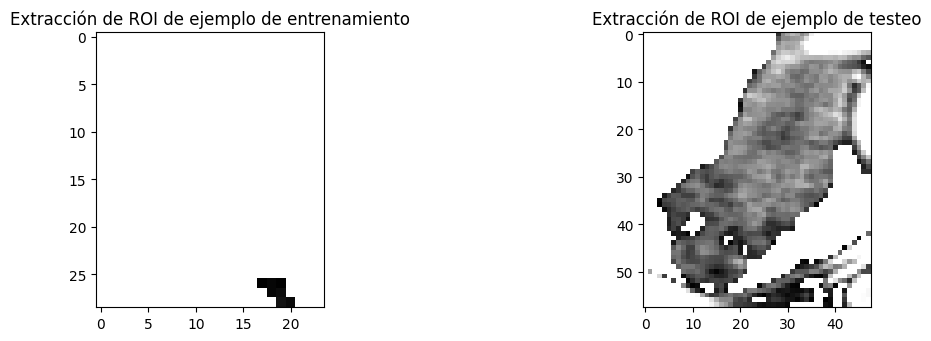

In [59]:
margin = 4
level = 50
window_width = 200

roi_exam_train = roiExtraction(img_exam_train, mask_exam_train, margin)
roi_exam_test = roiExtraction(img_exam_test, mask_exam_test, margin)

f = plt.figure(figsize=(10, 10), frameon=True)
f.add_subplot(1, 3, 1)
plt.title("Extracción de ROI de ejemplo de entrenamiento")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(roi_exam_train, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')

f.add_subplot(1, 3, 3)
plt.title("Extracción de ROI de ejemplo de testeo")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(roi_exam_test, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')

(64, 64) (64, 64)


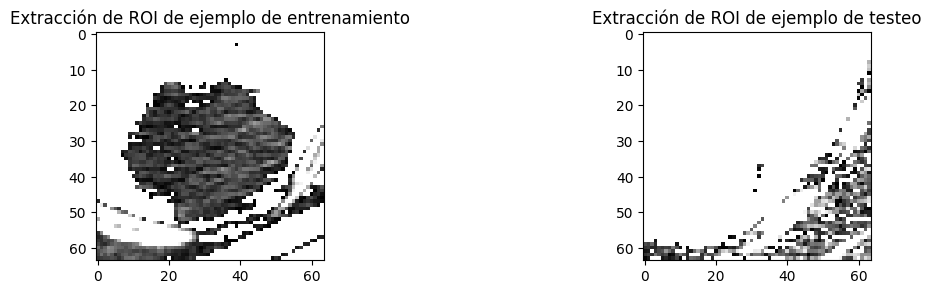

In [63]:
margin = 4
level = 50
window_width = 200
size = 64

stanford_roi_exam_train = roiExtractionSize(stanford_img_exam_train, stanford_mask_exam_train, size)
stanford_roi_exam_test = roiExtractionSize(stanford_img_exam_test, stanford_mask_exam_test, size)

print(stanford_roi_exam_train.shape, stanford_roi_exam_train.shape)

f = plt.figure(figsize=(10, 10), frameon=True)
f.add_subplot(1, 3, 1)
plt.title("Extracción de ROI de ejemplo de entrenamiento")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(stanford_roi_exam_train, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')

f.add_subplot(1, 3, 3)
plt.title("Extracción de ROI de ejemplo de testeo")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(stanford_roi_exam_test, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')

## Implementación de K-Fold

Se implementa *K-Fold Stratified*. Esto es, con distribución de las clases balanceadas y aplicando el procesamiento de extracción de ROI.

In [66]:
from sklearn.model_selection import StratifiedKFold

img_size = 64
def get_stratified_stanford_kfold_datasets(k=5, random_seed=None):
    '''Creates stratified k-fold cross-validation datasets with balanced class distribution.
    Returns a list of k pairs of training and testing datasets with balanced classes.'''
    
    # Set the random seed
    random.seed(random_seed)

    pos_patients = []
    neg_patients = []
    
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)

    # Create labels for patients (1 for positive, 0 for negative)
    labels = [1] * len(pos_patients) + [0] * len(neg_patients)
    patients = pos_patients + neg_patients
    # Initialize stratified k-fold cross-validator
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

    fold_datasets = []
    
    for train_indices, test_indices in skf.split(patients, labels):
        training_patients = [patients[i] for i in train_indices]
        testing_patients = [patients[i] for i in test_indices]

        # Create dictionaries to hold the training and testing data
        training_data = {patient: stanford_dataset[patient] for patient in training_patients}
        testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}

        # Create a generator for the training dataset
        def generate_training_data():
            for patient_id in training_patients:
                patient_data = training_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    yield data['patient_id'], roi_extract, data['label']

        # Create a TensorFlow Dataset from the generator
        training_dataset = tf.data.Dataset.from_generator(
            generate_training_data,
            output_signature=(
                tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
                tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
            )
        )

        # Create a generator for the testing dataset
        def generate_testing_data():
            for patient_id in testing_patients:
                patient_data = testing_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    yield data['patient_id'], roi_extract, data['label']

        # Create a TensorFlow Dataset from the generator
        testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
                tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
            )
        )

        fold_datasets.append((training_dataset, testing_dataset))

    return fold_datasets


In [67]:
get_stratified_stanford_kfold_datasets()

[(<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
  <_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>),
 (<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
  <_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(None, None), dtype=tf.uint16, name=None), TensorSpec(shape=(), dtype=tf.int6